# Лабораторная работа №2

## 2.1. Эволюция замкнутых квантовых систем

In [1]:
import numpy as np
from scipy.linalg import expm
from scipy.linalg import sqrtm
import copy

Для генерации случайного смешанного квантового состояния заданного ранга воспользуемся классом $\operatorname{State}()$, написанном для Лабораторной работы №1.

In [2]:
class State(object):
    def __init__(self):
        self.state = None
        self.dim = None
        self.phys_ind = []

    def get_state(self):
        return self.state

    def gen_random_state(self, d, k):
        self.dim = d * k
        self.phys_ind = [d, k]
        self.state = np.random.randn(*self.phys_ind) + 1j * np.random.randn(*self.phys_ind)
        self.state = self.state / np.sqrt(np.sum(self.state * np.conjugate(self.state)))

    def get_random_sub_rho(self, d, k):
        state = np.reshape(self.state, [1, d, k, 1])
        global_rho = np.tensordot(state, np.conjugate(state), axes=([3], [0]))
        global_rho = np.reshape(global_rho, [d, k, d, k])
        rho = np.trace(global_rho, axis1=1, axis2=3)
        return rho

Генерируем случайное смешанное начальное состояние $\rho_0$ двух кубитов (d = 4) ранга 2 (k = 2).

In [3]:
d = 4
k = 2
state = State()
state.gen_random_state(d, k)
rho_0 = state.get_random_sub_rho(d, k)

Класс $\operatorname{Ham}()$ отвечает за вычисление Гамильтониана в определённый момент времени и вычисление коммутатора Гамильтониана с матрицей плотности $\rho$.

In [4]:
class Ham(object):
    def __init__(self):
        self.sigma_x = np.array([[0, 1],
                                 [1, 0]], dtype=complex)
        self.sigma_y = np.array([[0, -1j],
                                 [1j, 0]], dtype=complex)
        self.sigma_z = np.array([[1, 0],
                                 [0, -1]], dtype=complex)
        self.hams = [np.kron(self.sigma_x, self.sigma_z), np.kron(self.sigma_z, self.sigma_x)]
    
    def get_ham(self, t):
        return np.sin(2 * t) * self.hams[0] + np.cos(4 * t) * self.hams[1]
    
    def get_comm(self, rho, t):
        ham = self.get_ham(t)
        return np.dot(ham, rho) - np.dot(rho, ham)

Класс $\operatorname{Evolution}()$ отвечает за вычисление эволюции матрицы плотности $\rho(t)$ при заданной начальной матрице плотности $\rho_0$. Метод класса evolution_ODE() вычисляет эволюцию матрицы плотности с использованием численного решения (метода конечных разностей) уравнения фон Неймана: $\dfrac{\partial \rho}{\partial t} = -i [H, \rho]$. Метод класса evolution_EXPM() вычисляет эволюцию матрицы плотности с использованием оператора унитарной эволюции на малых временных шагах, на которых мы считаем Гамильтониан постоянным: $U(t, t + \Delta t) = \exp{(-i H(t) \Delta t)}$, при этом $\rho(t + \Delta t) = U(t, t + \Delta t) \rho(t) U^{\dagger}(t, t + \Delta t)$.

In [5]:
class Evolution(object):
    def __init__(self):
        self.rho = None
        self.ham = None
        self.list_rho = None
        self.final_rho = None
    
    def set_rho(self, rho):
        self.rho = copy.copy(rho)
    
    def set_ham(self, ham):
        self.ham = ham
    
    def evolution_ODE(self, time_evolution, dt):
        self.list_rho = [copy.copy(self.rho)]
        t = 0
        while (t < time_evolution):
            self.rho += -1j * self.ham.get_comm(self.rho, t) * dt
            self.list_rho.append(copy.copy(self.rho))
            t += dt
        self.final_rho = self.list_rho[-1]
    
    def evolution_EXPM(self, time_evolution, dt):
        self.list_rho = [copy.copy(self.rho)]
        t = 0
        while (t < time_evolution):
            U = expm(-1j * self.ham.get_ham(t) * dt)
            self.rho = np.dot(U, np.dot(self.rho, np.conjugate(U).T))
            self.list_rho.append(copy.copy(self.rho))
            t += dt
        self.final_rho = self.list_rho[-1]
            
    
    def get_rho(self):
        return self.rho
    
    def get_list_rho(self):
        return self.list_rho
    
    def get_final_rho(self):
        return self.final_rho

Добавим вспомогательную функцию, которая будет считать фиделити между двумя смешанными квантовыми состояниями.

In [6]:
def fidelity(rho, sigma):
    return np.abs(np.trace(sqrtm(sqrtm(rho) @ sigma @ sqrtm(rho)))) ** 2

Также добавим функцию, которая будет вычислять значения фиделити во все моменты временной сетки.

In [7]:
def get_fidelity_evolution(time_evolution, dt, ham, rho_0):
    t = 0
    timeslots = [t]
    while (t < time_evolution):
        timeslots.append(t)
        t += dt
    timeslots = np.array(timeslots)
    evolution = Evolution()
    evolution.set_rho(rho_0)
    evolution.set_ham(ham)
    evolution.evolution_ODE(time_evolution, dt)
    list_rho_ODE = evolution.list_rho
    list_F_ODE = np.array([fidelity(rho_ODE, rho_0) for rho_ODE in list_rho_ODE])
    evolution.set_rho(rho_0)
    evolution.set_ham(ham)
    evolution.evolution_EXPM(time_evolution, dt)
    list_rho_EXPM = evolution.list_rho
    list_F_EXPM = np.array([fidelity(rho_EXPM, rho_0) for rho_EXPM in list_rho_EXPM])
    return timeslots, list_F_ODE, list_F_EXPM

In [8]:
time_evolution = 1.0
ham = Ham()

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

Функция, которая строит график временной эволюции фиделити.

In [10]:
def plot_fidelity_evolution(timeslots, list_F_ODE, list_F_EXPM, dt):
    fig, ax = plt.subplots()
    plt.plot(timeslots, list_F_ODE, lw=3, alpha=1, label='ODE, dt = ' + str(dt))
    plt.plot(timeslots, list_F_EXPM, '--', lw=3, alpha=1, label='EXPM, dt = ' + str(dt))
    ax.legend(loc='lower left')
    ax.minorticks_off()
    plt.xlabel(r'$t$', fontsize=15)
    plt.ylabel(r'$F(\rho(t), \rho(0))$', fontsize=15)
    plt.show()

In [11]:
timeslots_1, list_F_ODE_1, list_F_EXPM_1 = get_fidelity_evolution(time_evolution, 0.1, ham, rho_0)
timeslots_2, list_F_ODE_2, list_F_EXPM_2 = get_fidelity_evolution(time_evolution, 0.01, ham, rho_0)
timeslots_3, list_F_ODE_3, list_F_EXPM_3 = get_fidelity_evolution(time_evolution, 0.001, ham, rho_0)

Строим графики зависимостей $F(\rho(t), \rho(0))$ от времени $t$.

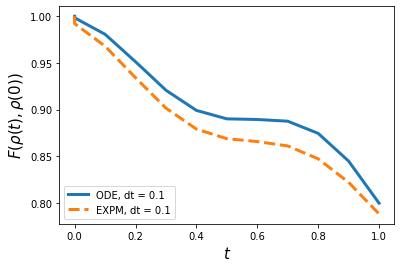

In [12]:
plot_fidelity_evolution(timeslots_1, list_F_ODE_1, list_F_EXPM_1, 0.1)

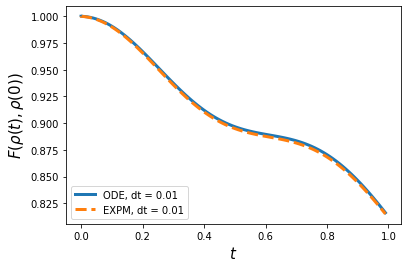

In [13]:
plot_fidelity_evolution(timeslots_2, list_F_ODE_2, list_F_EXPM_2, 0.01)

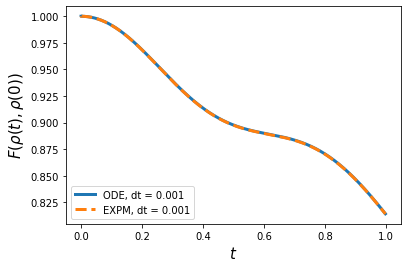

In [14]:
plot_fidelity_evolution(timeslots_3, list_F_ODE_3, list_F_EXPM_3, 0.001)

## 2.2. Эволюция открытых квантовых систем

Рассматриваемый процесс - случайный фазовый шум с параметром $p = 0.2$.

In [15]:
p = 0.2

In [16]:
E_0 = np.sqrt(p) * np.array([[1, 0], 
                             [0, 1]], dtype=complex)
E_1 = np.sqrt(1 - p) * np.array([[1, 0], 
                                 [0, -1]], dtype=complex)
list_kraus = [E_0, E_1]

Вычисляем $\chi$-матрицу Чоя-Ямилковского для рассматриваемого квантового процесса: $\chi = d (I \otimes \mathcal{E})(|\Phi\rangle \langle \Phi |)$, где $|\Phi\rangle = \dfrac{1}{\sqrt{d}} \sum_j |j\rangle \otimes |j\rangle$.

Сначала генерируем $|\Phi\rangle = \dfrac{1}{\sqrt{d}} \sum_j |j\rangle \otimes |j\rangle$.

In [17]:
phi = (1 / np.sqrt(2)) * np.array([1, 0, 0, 1], dtype=complex)
phi_tensor = phi.reshape(2, 2)

Затем вычисляем тензор плотности $\rho_{i_1 i_2 j_1 j_2} = \psi_{i_1 i_2} \psi^{*}_{j_1 j_2}$.

In [18]:
rho_phi_tensor = np.tensordot(phi_tensor.reshape(2, 2, 1), phi_tensor.reshape(1, 2, 2).conjugate(), axes=([2], [0]))

Теперь вычиялем $\chi$-матрицу: $\chi_{i_2 i_1 j_1 j_2} = ((I \otimes \mathcal{E})|\Phi\rangle \langle \Phi |)_{i_2 i_1 j_1 j_2} = \sum_{k, m, n} E_{k i_2 m} \rho_{i_1 m j_1 n} E^{\dagger}_{k n j_2}$.

In [19]:
chi_matrix = np.zeros((4, 4), dtype=complex)
for kraus in list_kraus:
    chi_tensor_part_sum = np.tensordot(kraus, np.tensordot(rho_phi_tensor, kraus.T.conjugate(), axes=([3], [0])), axes=([1], [1]))
    chi_tensor_part_sum = np.transpose(chi_tensor_part_sum, axes=(1, 0, 2, 3))
    chi_matrix += 2 * chi_tensor_part_sum.reshape(4, 4)

In [20]:
print(chi_matrix)

[[ 1. +0.j  0. +0.j  0. +0.j -0.6+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [-0.6+0.j  0. +0.j  0. +0.j  1. +0.j]]


Убеждаемся, что частицный след по второй подсистеме от $\chi$-матрицы даёт единичную матрицу.

In [21]:
chi_tensor = np.reshape(chi_matrix, [2, 2, 2, 2])
chi_partial_trace_2 = np.trace(chi_tensor, axis1=1, axis2=3)
print(chi_partial_trace_2)

[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


Вычисляем матрицу эволюции $G$ для рассматриваемого процесса: $G = \sum_{k} E^{*}_k \otimes E_k$.

In [22]:
G = np.zeros((4, 4), dtype=complex)
for kraus in list_kraus:
    G += np.kron(np.conjugate(kraus), kraus)

In [23]:
print(G)

[[ 1. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.6+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -0.6+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  1. +0.j]]


Генерируем случайное смешанное однокубитное квантвоое состояние ранга 2.

In [24]:
d = 2
k = 2
state = State()
state.gen_random_state(d, k)
rho_0 = state.get_random_sub_rho(d, k)

Для расчёта эволюции используем операторное разложение Крауса: $\rho' = \sum_{k} E_k \rho E_k^{\dagger}$.

In [25]:
rho_final_kraus = np.zeros((2, 2), dtype=complex)
for kraus in list_kraus:
    rho_final_kraus += kraus @ rho_0 @ kraus.T.conjugate()

In [26]:
print(rho_final_kraus)

[[ 0.22202732+0.j         -0.18559649-0.11595454j]
 [-0.18559649+0.11595454j  0.77797268+0.j        ]]


Для расчёта эволюции используем $\chi$-матрицу Чоя-Ямилковского: $\rho' = \sum_{i, j} \chi_{ij} A_i \rho A^{\dagger}_j$.

In [27]:
rho_final_chi = np.zeros((2, 2), dtype=complex)
A_1 = np.array([[1, 0], 
                [0, 0]], dtype=complex)
A_2 = np.array([[0, 0], 
                [1, 0]], dtype=complex)
A_3 = np.array([[0, 1], 
                [0, 0]], dtype=complex)
A_4 = np.array([[0, 0], 
                [0, 1]], dtype=complex)
list_A = [A_1, A_2, A_3, A_4]
for i in range(4):
    for j in range(4):
        rho_final_chi += chi_matrix[i, j] * (list_A[i] @ rho_0 @ list_A[j].T.conjugate())

In [28]:
print(rho_final_chi)

[[ 0.22202732+0.j         -0.18559649-0.11595454j]
 [-0.18559649+0.11595454j  0.77797268+0.j        ]]


Для расчёта эволюции используем матрицу супероператора $G$: $\operatorname{Col}(\rho') = G \operatorname{Col} \rho$.

In [29]:
def col(matrix):
    return np.reshape(matrix, -1, order='F').reshape((4, 1))

In [30]:
rho_final_super = np.reshape(G @ col(rho_0), (2, 2), order='F')

In [31]:
print(rho_final_super)

[[ 0.22202732+0.j         -0.18559649-0.11595454j]
 [-0.18559649+0.11595454j  0.77797268+0.j        ]]


Видно, что результаты, полученные тремя методами для эволюции матрицы плотности $\rho$ получились одинаковыми. Для уверенности в этом результате посчитаем фиделити между матрицами плотности, полученными $1$ и $2$ способами, и $2$ и $3$ способами.

In [32]:
print(fidelity(rho_final_kraus, rho_final_chi), fidelity(rho_final_chi, rho_final_super))

0.9999999999999987 1.0000000000000013
